# Import essential packages

In [3]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
import time
import seaborn as sns
import os
from tqdm import trange
from sklearn.metrics import mean_squared_error as MSE
import numpy as np
from sklearn.metrics import accuracy_score
import argparse
import torch
import torch.utils.data as data_utils
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
# from dataloader import MnistBags
from mnist_bags_loader import MnistBags
from model import Attention, GatedAttention
from DataTransform import convert_data

## 1. Import mnist data

In [4]:
target_number = 9 # bags have a positive labels if they contain at least one 9
mean_bag_length = 20 # average bag length
var_bag_length = 0 # variance of bag length
num_bags_train = 100 # the number of bags in training set
num_bags_test = 200 # the number of bags in testing set
seed = 5 # random seed
use_cuda = torch.cuda.is_available()

In [5]:
import torch
torch.zeros(3)

tensor([0., 0., 0.])

In [6]:
use_cuda = torch.cuda.is_available()
print('Load Train and Test Set')
# loader_kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = data_utils.DataLoader(MnistBags(target_number= target_number,
                                               mean_bag_length= mean_bag_length,
                                               var_bag_length= var_bag_length,
                                               num_bag= num_bags_train,
                                               seed= seed,
                                               train=True),
                                     batch_size=1,
                                     shuffle=True,)

test_loader = data_utils.DataLoader(MnistBags(target_number= target_number,
                                              mean_bag_length= mean_bag_length,
                                              var_bag_length= var_bag_length,
                                              num_bag= num_bags_test,
                                              seed= seed,
                                              train=False),
                                    batch_size=1,
                                    shuffle=False,)

Load Train and Test Set


9913344it [00:00, 16444411.11it/s]                             


Extracting ../datasets\MNIST\raw\train-images-idx3-ubyte.gz to ../datasets\MNIST\raw



29696it [00:00, 29747803.10it/s]         


Extracting ../datasets\MNIST\raw\train-labels-idx1-ubyte.gz to ../datasets\MNIST\raw



1649664it [00:00, 19875768.59it/s]         


Extracting ../datasets\MNIST\raw\t10k-images-idx3-ubyte.gz to ../datasets\MNIST\raw



5120it [00:00, 5121592.29it/s]          


Extracting ../datasets\MNIST\raw\t10k-labels-idx1-ubyte.gz to ../datasets\MNIST\raw



## 2. Modeling

### 2.1 Configurations

In [7]:
from net import *
from modules.criterion import *
data_type = "matrix" # matrix / tensor,  default = matrix
model_type = "nn" # logistic / nn, default = nn
img_sz = (28,28)
model = MIL(img_sz,data_type,model_type)
### setting GPU
use_cuda = torch.cuda.is_available()
print("is cuda available: ",use_cuda)
if use_cuda:
    model = model.cuda()
learning_rate = 1 * 1e-3 ## 4
### define the optimization algorithm
optimizer = optim.Adam(model.parameters(), lr= learning_rate)
## define criterion
criterion = MLE(p1 = 4, p2 = 5)
## the total number of iteration 
num_epochs = 50 ## 50
## weight decay
decay_weight = 1 # 0.98

_lambda = 0 * 1e-3  ## 0.01 default

is cuda available:  True


### 2.3 Training

In [8]:
from sklearn import metrics
# def train(epoch):
for epoch in range(1,num_epochs+1):
    model.train()
    train_loss = 0.
    # train_acc = 0.
    Y_label = []
    Y_hat_label = []
    for batch_idx,(data,label) in enumerate(train_loader):
        # data = torch.unsqueeze(data,2)
        bag_label = label[0] + 0.  ## convert true-false to 1-0
        # ins_label = torch.tensor([0])
        ins_label = label[1] + 0. 
        if use_cuda:
            data, bag_label = data.cuda(), bag_label.cuda()
        # data, bag_label = Variable(data), Variable(bag_label)
        optimizer.zero_grad()
        # calculate loss and metrics
        y_hat,_= model(data) #data.float()
        ### presence-based
        y_hat_label = 1 - torch.prod(1/( 1 + torch.exp(y_hat)))
        ## lower-bound
        # y_hat_label = 1 - 1/(1+torch.exp(1/30 * torch.sum(y_hat)))
        # y_hat_label = torch.ge(y_hat_label,0.5) + 0
        loss = criterion(bag_label,ins_label, y_hat,_lambda)
        train_loss += loss.item()
        Y_label.append(bag_label.squeeze().detach().cpu().numpy())
        Y_hat_label.append(y_hat_label.squeeze().detach().cpu().numpy())
        # backward pass
        loss.backward()
        # step
        optimizer.step()
    # calculate loss and error for epoch
    train_loss /= len(train_loader)
    # train_acc = accuracy_score(Y_label,Y_hat_label)        
    fpr, tpr, thresholds = metrics.roc_curve(Y_label, Y_hat_label)
    train_auc = metrics.auc(fpr, tpr)   
    # train_error /= len(train_loader)
    if epoch % 5 == 0:
    # print('Epoch: {}, Loss: {:.4f}, Train error: {:.4f}'.format(epoch, train_loss.cpu().numpy()[0], train_error))
        print('Epoch: {}, Loss: {:.8f}, Train auc: {:.6f}'.format(epoch, train_loss, train_auc))

Epoch: 5, Loss: 0.24585952, Train auc: 0.970800
Epoch: 10, Loss: 0.01471994, Train auc: 1.000000
Epoch: 15, Loss: 0.00375259, Train auc: 1.000000
Epoch: 20, Loss: 0.00183956, Train auc: 1.000000
Epoch: 25, Loss: 0.00107945, Train auc: 1.000000
Epoch: 30, Loss: 0.00065483, Train auc: 1.000000
Epoch: 35, Loss: 0.00043142, Train auc: 1.000000
Epoch: 40, Loss: 0.00029070, Train auc: 1.000000
Epoch: 45, Loss: 0.00020036, Train auc: 1.000000
Epoch: 50, Loss: 0.00014496, Train auc: 1.000000


In [9]:
model.parameters

<bound method Module.parameters of MIL(
  (feature_extractor_part1): Sequential(
    (0): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (feature_extractor_part2): Sequential(
    (0): Linear(in_features=2450, out_features=1, bias=False)
  )
)>

### 2.4 Testing

<AxesSubplot:ylabel='Density'>

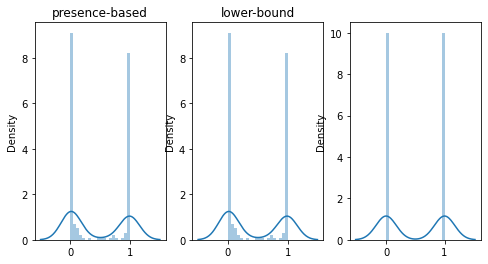

In [10]:
model.eval()
Y_label = []
Y_hat_label = []
ty_hat_list = []
tdata_list = []
ins_label_list = []
for batch_idx, (data, label) in enumerate(test_loader):
    # data = torch.unsqueeze(data,2)
    bag_label = label[0] + 0  ## convert true-false to 1-0
    ins_label = label[1] + 0. 
    if use_cuda:
        data, bag_label = data.cuda(), bag_label.cuda()
    y_hat,_ = model(data.float())
    ### presence-based
    y_hat_label = 1 - torch.prod(1/( 1 + torch.exp(y_hat)))
    ### lower-bound
    # y_hat_label = 1 - 1/(1+torch.exp(1/30 * torch.sum(y_hat)))
    ## one-hot, thresholding
    # y_hat_label = torch.ge(y_hat_label,0.5) + 0
    Y_label.append(bag_label.squeeze().detach().cpu().numpy())
    Y_hat_label.append(y_hat_label.squeeze().detach().cpu().numpy())
    # ty_hat = np.round((1/( 1 + torch.exp(-y_hat))).detach().cpu().numpy(),100)
    ty_hat = (1/( 1 + torch.exp(-y_hat))).detach().cpu().numpy()
    tdata = data.detach().cpu().numpy().squeeze().squeeze()
    ty_hat_list.append(ty_hat)
    tdata_list.append(tdata)
    ins_label_list.append(ins_label.numpy())
Y_hat_prob = []
for k in range(len(ty_hat_list)):
    Y_hat_prob.append(1- reduce(lambda x,y:x*y,1- ty_hat_list[k]))
    
import warnings
warnings.filterwarnings("ignore")
fig,ax = plt.subplots(figsize = (8,4))
### presence-based
plt.subplot(1,3,1)
sns.distplot(Y_hat_prob,bins = 20)
plt.title("presence-based")
## lower-bound
plt.subplot(1,3,2)
plt.title("lower-bound")
sns.distplot(Y_hat_label,bins = 20)
plt.subplot(1,3,3)
sns.distplot(Y_label,bins = 20)

In [11]:
import os 
os.getcwd()

'c:\\Users\\sanyo\\OneDrive - connect.hku.hk\\Codes\\CodesForGithub\\IndividualizedRegionDetection'

In [12]:
from utils import *
from sklearn import metrics

Y_hat_prob_ = [1 if x >=0.5 else 0 for x in Y_hat_prob]
Y_hat_label_ = [1 if x >=0.5 else 0 for x in Y_hat_label]

fpr, tpr, thresholds = metrics.roc_curve(Y_label, Y_hat_prob)
TPR,TNR,ACC = cls_measure(Y_label,Y_hat_prob_)
test_auc = np.round(metrics.auc(fpr, tpr),5)
print("---------presence-based + lower bound--------")
print("test auc: ",test_auc)
print("the acc of testing: ",ACC)
print("the tpr of testing: ",np.round(TPR,5))
print("the tnr of testing: ",np.round(TNR,5))
print("---------lower-bound--------")
fpr, tpr, thresholds = metrics.roc_curve(Y_label, Y_hat_label)
TPR,TNR,ACC = cls_measure(Y_label,Y_hat_label_)
print("test auc: ",np.round(metrics.auc(fpr, tpr),5))
print("the acc of testing: ",ACC)
print("the tpr of testing: ",np.round(TPR,5))
print("the tnr of testing: ",np.round(TNR,5))

# wandb.log({'auc': test_auc, 'tpr': TPR, "tnr":TNR, "acc":ACC})

---------presence-based + lower bound--------
test auc:  0.9695
the acc of testing:  0.93
the tpr of testing:  0.89
the tnr of testing:  0.97
---------lower-bound--------
test auc:  0.9695
the acc of testing:  0.93
the tpr of testing:  0.89
the tnr of testing:  0.97


In [80]:
from sklearn import metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve

ins_label_all = []
for i in ins_label_list:
    ins_label_all.extend(i.flatten())

ins_hat_all = []
for i in ty_hat_list:
    ins_hat_all.extend(i.flatten())

precision_IRD, recall_IRD,th = precision_recall_curve(ins_label_all, ins_hat_all)
auprc_IRD = metrics.auc(recall_IRD, precision_IRD)
print("auprc of auc_IRD: ",auprc_IRD)

auprc of auc_IRD:  0.9190739241057325


### 2.5 Plot

Ground truth:  1
the probability for a bag including number 9:  [1.]


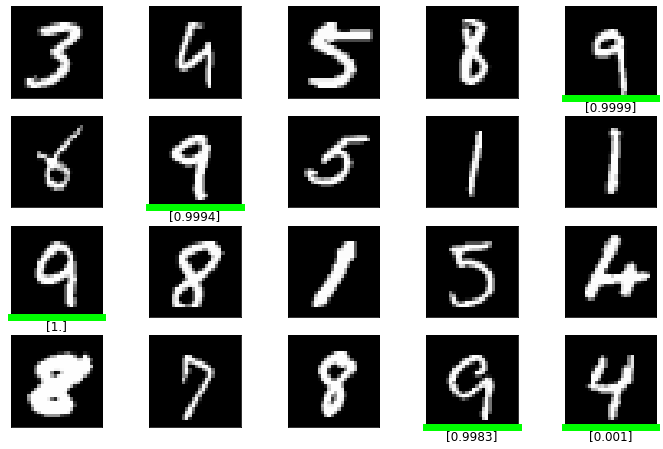

In [13]:
from functools import reduce
from pathlib import Path
fig,ax = plt.subplots(figsize = (12,40))
k = 4  ## k = 4,6 is a illustrative example
k_y_hat = ty_hat_list[k].squeeze()
top_5_idx = k_y_hat.argsort()[-1:-6:-1]
top_5_y_hat = k_y_hat[top_5_idx]
# ins_label = ins_label_list[k]
print("Ground truth: ",Y_label[k])
print("the probability for a bag including number 9: ",1- reduce(lambda x,y:x*y,1- ty_hat_list[k]))
for i in range(len(ty_hat_list[k])):
    plt.subplot(20,5,i+1)
    if i in top_5_idx:
        ax = plt.gca()
        ax.spines["bottom"].set_linewidth(7) 
        # ax.spines["top"].set_color("red")
        # ax.spines["left"].set_color("red")
        # ax.spines["right"].set_color("red")
        # ax.spines["bottom"].set_color("red")
        ax.spines["bottom"].set_color("#00FF00")
        # plt.title("Prob: " + str(ty_hat_list[k][i]), color = "orange")
        plt.title(str(np.round(ty_hat_list[k][i],4)), color = "black", loc = "center", y = -0.2)
        # ax.set_title("a")
    # if ins_label[i]:
    #     ax = plt.gca()
    #     ax.spines["bottom"].set_linewidth(5) 
    #     ax.spines["bottom"].set_color("#00FF00")
    plt.imshow(tdata_list[k][i,:,:],"gray")
    plt.xticks([])
    plt.yticks([])
# save_dir = r"D:\OneDrive\OneDrive - connect.hku.hk\Codes\IndividualizedRegionSelectionMIL\res_data"
save_dir = r"C:\\Users\\sanyo\\OneDrive - connect.hku.hk\\Codes\\IndividualizedRegionSelectionMIL\\res_data"
# plt.savefig(Path(save_dir,"MNIST_20_green.pdf"), dpi = 300, bbox_inches = "tight", pad_inches = 0)